In [70]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from string import punctuation
import os
from os import listdir
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob

In [2]:
def file_to_string(filename):
 '''Opens the input text file and
 returns a string of all its text.'''
 file = open(filename, 'r')
 text = file.read()
 file.close()
 text = text.replace('\n', ' ')
 text = text.replace('  ', ' ')
 return text

In [3]:
cd ..

/Users/kamilapalys/Desktop/school/data450/capstone


In [4]:
pwd

'/Users/kamilapalys/Desktop/school/data450/capstone'

In [5]:
# example of using the function

filepath = 'data/text/cnn_trump.txt'
test_txt = file_to_string(filepath)
test_txt

"Donald Trump faces more than 30 counts related to business fraud in an indictment from a Manhattan grand jury, according to two sources familiar with the case – the first time in American history that a current or former president has faced criminal charges. Trump is expected to appear in court on Tuesday. The indictment has been filed under seal and will be announced in the coming days. The charges are not publicly known at this time. Manhattan District Attorney Alvin Bragg’s office has been investigating the former president in connection with his alleged role in a hush money payment scheme and cover-up involving adult film star Stormy Daniels that dates to the 2016 presidential election. Grand jury proceedings are secret, but a source familiar with the case told CNN that a witness gave about 30 minutes of testimony before it voted to indict Trump. The decision is sure to send shockwaves across the country, pushing the American political system – which has never seen one of its ex-l

In [6]:
# initialize a dictionary to be able to find the original word from the stemmed word
stemmed_dict = {}

# how to later access the key by the value
#value = {i for i in dic if dic[i]=="B"}
#print("key by value:",value

In [7]:
def clean_text(text):
    '''Takes in a string of text and cleans it by converting
    to lowercase, removing punctuation, removing stopwords, 
    and stemming. Returns the new string.'''
    ps = PorterStemmer()
    # create list of stopwords 
    stopwords_list = stopwords.words('english')
    # make the text lowercase
    text = text.lower()
    text = text.replace('—', ' ')
    # convert to ascii characters
    text = text.encode("ascii", "ignore").decode()
    for chr in text:
        # only keep characters in the string that are not punctuation symbols
        if (chr in string.punctuation or chr in string.digits):
            text = text.replace(chr, ' ')
    text = text.replace('  ', ' ')
    # stem the tokens within the text
    tokens = text.split(" ")
    stemmed = []
    for token in tokens[:-2]:
        # only include new token in the cleaned list if not a stopword
        if token not in stopwords_list:
            stemmed_word = ps.stem(token)
            stemmed.append(stemmed_word)
            if token not in stemmed_dict:
                stemmed_dict[token] = stemmed_word
    stemmed.append(tokens[-2])
    stemmed.append(tokens[-1])
    cleaned_text = " ".join(stemmed)
    cleaned_text = cleaned_text.replace('  ', ' ')
    return cleaned_text

In [10]:
# looping through all text files to apply preprocessing functions
file_list = []
article_docs = []
dir = os.listdir('data/text/')
dir.sort()
for filename in dir:
    filepath = os.path.join('data/text/', filename)
    file_list.append(f"{filepath}")
    if filename.split(".")[-1] == "txt":
        article_string = file_to_string(filepath)
        new_string = clean_text(article_string)
        article_docs.append(new_string)

# convert the list of article strings into a binary-value dataframe
t = Tokenizer()
t.fit_on_texts(article_docs)
print(t)
encoded_docs = t.texts_to_matrix(article_docs, mode='binary')
words = [x for x in t.word_index.keys()]
binary_df = pd.DataFrame(data = encoded_docs[:, 1:], columns=words)
# List of conditions
source_conditions = [
      binary_df['abcarticle'] == 1
    , binary_df['bbcarticle'] == 1
    , binary_df['cnnarticle'] == 1
    , binary_df['foxarticle'] == 1
    , binary_df['nbcarticle'] == 1
    , binary_df['nyparticle'] == 1
    , binary_df['nytarticle'] == 1
    , binary_df['wparticle'] == 1
    , binary_df['wsjarticle'] == 1
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# List of conditions
topic_conditions = [
      binary_df['affirmativearticle'] == 1
    , binary_df['balloonarticle'] == 1
    , binary_df['bidenarticle'] == 1
    , binary_df['hamasarticle'] == 1
    , binary_df['pentagonarticle'] == 1
    , binary_df['santosarticle'] == 1
    , binary_df['tanksarticle'] == 1
    , binary_df['trumparticle'] == 1
]
# List of values to return
topic_choices  = [
      "Supreme Court Ruling on Affirmative Action"
    , "Chinese Surveillance Balloon"
    , "Biden's Low Approval Rates in Polls"
    , "The Deadliest Attack by Hamas"
    , "Pentagon Documents Leak"
    , "George Santos' Expulsion from Congress"
    , "U.S. and Germany Send Tanks to Ukraine"
    , "Trump's Indictment"
]
# create a new source column 
binary_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")

# create a new topic column
binary_df["article_topic"] = np.select(topic_conditions, topic_choices, "ERROR")

binary_df.head()

,said,trump,biden,offici,mr,u,israel,presid,tank,hous,...,messr,overlap,vs,convert,marku,schreiber,riski,extort,article_source,article_topic
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Supreme Court Ruling on Affirmative Action
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Chinese Surveillance Balloon
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Biden's Low Approval Rates in Polls
3,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,The Deadliest Attack by Hamas
4,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Pentagon Documents Leak


In [11]:
# check what word a given stemmed word represents 
value = {i for i in stemmed_dict if stemmed_dict[i]=="marku"}
print("key by value:",value)

key by value: {'markus'}


In [12]:
encoded_docs_freq = t.texts_to_matrix(article_docs, mode='count')
freq_df = pd.DataFrame(data = encoded_docs_freq[:, 1:], columns=words)
# List of conditions
source_conditions = [
      freq_df['abcarticle'] == 1
    , freq_df['bbcarticle'] == 1
    , freq_df['cnnarticle'] == 1
    , freq_df['foxarticle'] == 1
    , freq_df['nbcarticle'] == 1
    , freq_df['nyparticle'] == 1
    , freq_df['nytarticle'] == 1
    , freq_df['wparticle'] == 1
    , freq_df['wsjarticle'] == 1
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# List of conditions
topic_conditions = [
      freq_df['affirmativearticle'] == 1
    , freq_df['balloonarticle'] == 1
    , freq_df['bidenarticle'] == 1
    , freq_df['hamasarticle'] == 1
    , freq_df['pentagonarticle'] == 1
    , freq_df['santosarticle'] == 1
    , freq_df['tanksarticle'] == 1
    , freq_df['trumparticle'] == 1
]
# List of values to return
topic_choices  = [
      "Supreme Court Ruling on Affirmative Action"
    , "Chinese Surveillance Balloon"
    , "Biden's Low Approval Rates in Polls"
    , "The Deadliest Attack by Hamas"
    , "Pentagon Documents Leak"
    , "George Santos' Expulsion from Congress"
    , "U.S. and Germany Send Tanks to Ukraine"
    , "Trump's Indictment"
]
# create a new source column 
freq_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")

# create a new topic column
freq_df["article_topic"] = np.select(topic_conditions, topic_choices, "ERROR")

freq_df.head()

,said,trump,biden,offici,mr,u,israel,presid,tank,hous,...,messr,overlap,vs,convert,marku,schreiber,riski,extort,article_source,article_topic
0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Supreme Court Ruling on Affirmative Action
1,30.0,0.0,5.0,28.0,0.0,15.0,0.0,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Chinese Surveillance Balloon
2,9.0,17.0,27.0,0.0,0.0,0.0,0.0,8.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Biden's Low Approval Rates in Polls
3,17.0,0.0,3.0,6.0,0.0,10.0,28.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,The Deadliest Attack by Hamas
4,9.0,0.0,0.0,5.0,0.0,20.0,2.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Pentagon Documents Leak


In [13]:
# create dataframe with tf-idf values

encoded_docs_tfidf = t.texts_to_matrix(article_docs, mode='tfidf')
tfidf_df = pd.DataFrame(data = encoded_docs_tfidf[:, 1:], columns=words)
# List of conditions
source_conditions = [
      tfidf_df['abcarticle'] != 0
    , tfidf_df['bbcarticle'] != 0
    , tfidf_df['cnnarticle'] != 0
    , tfidf_df['foxarticle'] != 0
    , tfidf_df['nbcarticle'] != 0
    , tfidf_df['nyparticle'] != 0
    , tfidf_df['nytarticle'] != 0
    , tfidf_df['wparticle'] != 0
    , tfidf_df['wsjarticle'] != 0
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# List of conditions
topic_conditions = [
      tfidf_df['affirmativearticle'] != 0
    , tfidf_df['balloonarticle'] != 0
    , tfidf_df['bidenarticle'] != 0
    , tfidf_df['hamasarticle'] != 0
    , tfidf_df['pentagonarticle'] != 0
    , tfidf_df['santosarticle'] != 0
    , tfidf_df['tanksarticle'] != 0
    , tfidf_df['trumparticle'] != 0
]
# List of values to return
topic_choices  = [
      "Supreme Court Ruling on Affirmative Action"
    , "Chinese Surveillance Balloon"
    , "Biden's Low Approval Rates in Polls"
    , "The Deadliest Attack by Hamas"
    , "Pentagon Documents Leak"
    , "George Santos' Expulsion from Congress"
    , "U.S. and Germany Send Tanks to Ukraine"
    , "Trump's Indictment"
]
# create a new source column 
tfidf_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")

# create a new topic column
tfidf_df["article_topic"] = np.select(topic_conditions, topic_choices, "ERROR")

tfidf_df.head()

,said,trump,biden,offici,mr,u,israel,presid,tank,hous,...,messr,overlap,vs,convert,marku,schreiber,riski,extort,article_source,article_topic
0,1.827036,0.000000,0.000000,0.000000,0.0,2.313275,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Supreme Court Ruling on Affirmative Action
1,3.081563,0.000000,2.267700,4.139471,0.0,3.594586,0.000000,1.881491,0.000000,1.871958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Chinese Surveillance Balloon
2,2.238584,5.086179,3.733245,0.000000,0.0,0.000000,0.000000,2.428008,0.000000,2.128570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Biden's Low Approval Rates in Polls
3,2.683881,0.000000,1.823774,2.667558,0.0,3.201528,6.446654,1.334974,0.000000,0.891998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,The Deadliest Attack by Hamas
4,2.238584,0.000000,0.000000,2.493348,0.0,3.873465,2.519533,1.334974,3.689062,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ABC News,Pentagon Documents Leak


In [257]:
article_docs

['suprem court thursday set new limit affirm action program case involv whether public privat colleg univers continu use race one factor among mani student admiss court held opinion conserv major written chief justic john robert harvard unc admiss program violat equal protect claus fourteenth amend vote  unc case  harvard case due recus justic ketanji brown jackson jackson serv board overs harvard earn undergradu law degre jackson justic sonia sotomayor justic elena kagan dissent two case court said blockbust case put affirm action use decad colleg univers address inequ diversifi campus spotlight suprem court repeatedli rule sinc  school may consid race applic pursu educ benefit divers student bodi long one factor among mani consid school use quota system student fair admiss conserv group su harvard univers univers north carolina race consciou admiss program alleg intent discrimin toward asian american applic suprem court rule favor group decis major ramif colleg admiss process u progr

In [14]:
# create a list of strings where each string is all articles from one source
source_docs = []

j = 0

for i in range(9):
    source = " ".join(article_docs[j].split()[:-2]) + " " + " ".join(article_docs[j+1].split()[:-2]) + " "\
        + " ".join(article_docs[j+2].split()[:-2]) + " " + " ".join(article_docs[j+3].split()[:-2]) + " "\
        + " ".join(article_docs[j+4].split()[:-2]) + " " + " ".join(article_docs[j+5].split()[:-2]) + " "\
        + " ".join(article_docs[j+6].split()[:-2]) + " " + " ".join(article_docs[j+7].split()[:-1])
    source_docs.append(source)
    j += 8

source_docs

['suprem court thursday set new limit affirm action program case involv whether public privat colleg univers continu use race one factor among mani student admiss court held opinion conserv major written chief justic john robert harvard unc admiss program violat equal protect claus fourteenth amend vote unc case harvard case due recus justic ketanji brown jackson jackson serv board overs harvard earn undergradu law degre jackson justic sonia sotomayor justic elena kagan dissent two case court said blockbust case put affirm action use decad colleg univers address inequ diversifi campus spotlight suprem court repeatedli rule sinc school may consid race applic pursu educ benefit divers student bodi long one factor among mani consid school use quota system student fair admiss conserv group su harvard univers univers north carolina race consciou admiss program alleg intent discrimin toward asian american applic suprem court rule favor group decis major ramif colleg admiss process u program 

In [18]:
# adjust the following code to create a dataframe with each row being all articles of one source

# convert the list of article strings into a binary-value dataframe
t = Tokenizer()
t.fit_on_texts(source_docs)
print(t)
encoded_source_docs = t.texts_to_matrix(source_docs, mode='tfidf')
words = [x for x in t.word_index.keys()]
tfidf_source_df = pd.DataFrame(data = encoded_source_docs[:, 1:], columns=words)
# List of conditions
source_conditions = [
      tfidf_source_df['abcarticle'] != 0
    , tfidf_source_df['bbcarticle'] != 0
    , tfidf_source_df['cnnarticle'] != 0
    , tfidf_source_df['foxarticle'] != 0
    , tfidf_source_df['nbcarticle'] != 0
    , tfidf_source_df['nyparticle'] != 0
    , tfidf_source_df['nytarticle'] != 0
    , tfidf_source_df['wparticle'] != 0
    , tfidf_source_df['wsjarticle'] != 0
]

# List of values to return
source_choices  = [
      "ABC News"
    , "BBC"
    , "CNN"
    , "Fox News"
    , "NBC News"
    , "New York Post"
    , "The New York Times"
    , "The Washington Post"
    , "The Wall Street Journal"
]

# create a new source column 
tfidf_source_df["article_source"] = np.select(source_conditions, source_choices, "ERROR")
tfidf_source_df.set_index('article_source', inplace=True)
tfidf_source_df.drop(['abcarticle', 'bbcarticle', 'cnnarticle', 'foxarticle',
                      'nbcarticle', 'nyparticle', 'nytarticle', 'wparticle',
                      'wsjarticle'], axis=1, inplace=True)
tfidf_source_df

,said,trump,biden,offici,mr,u,israel,presid,tank,hous,...,squelch,market,messr,overlap,vs,convert,marku,schreiber,riski,extort
article_source,,,,,,,,,,,,,,,,,,,,,
ABC News,3.591249,2.959536,3.099282,3.139834,1.173600,3.586612,2.824926,2.886101,2.886101,2.824926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BBC,3.280434,2.780642,2.335743,2.460363,3.283902,0.000000,2.460363,2.654383,2.780642,2.595992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CNN,3.698474,3.025425,2.976653,3.331000,0.693147,1.173600,3.225542,2.993325,3.126599,2.707902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fox News,3.055995,3.350161,2.824926,2.421451,0.693147,3.027179,2.866350,2.905262,2.625851,2.824926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NBC News,3.670441,3.311249,2.866350,2.654383,1.654053,3.445144,3.099282,2.531753,2.886101,2.531753,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
New York Post,3.340652,3.126599,2.757300,2.335743,1.654053,2.924302,3.085175,3.009575,2.421451,3.202199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The New York Times,3.584733,3.269825,2.993325,2.654383,4.166255,1.935100,1.347002,2.824926,2.564676,2.531753,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The Washington Post,3.785551,3.269825,3.269825,3.225542,0.000000,3.376459,2.976653,3.099282,2.976653,2.886101,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
The Wall Street Journal,3.849334,3.213976,2.866350,3.126599,3.919027,3.667067,2.905262,2.803166,2.923868,2.733076,...,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748,1.704748


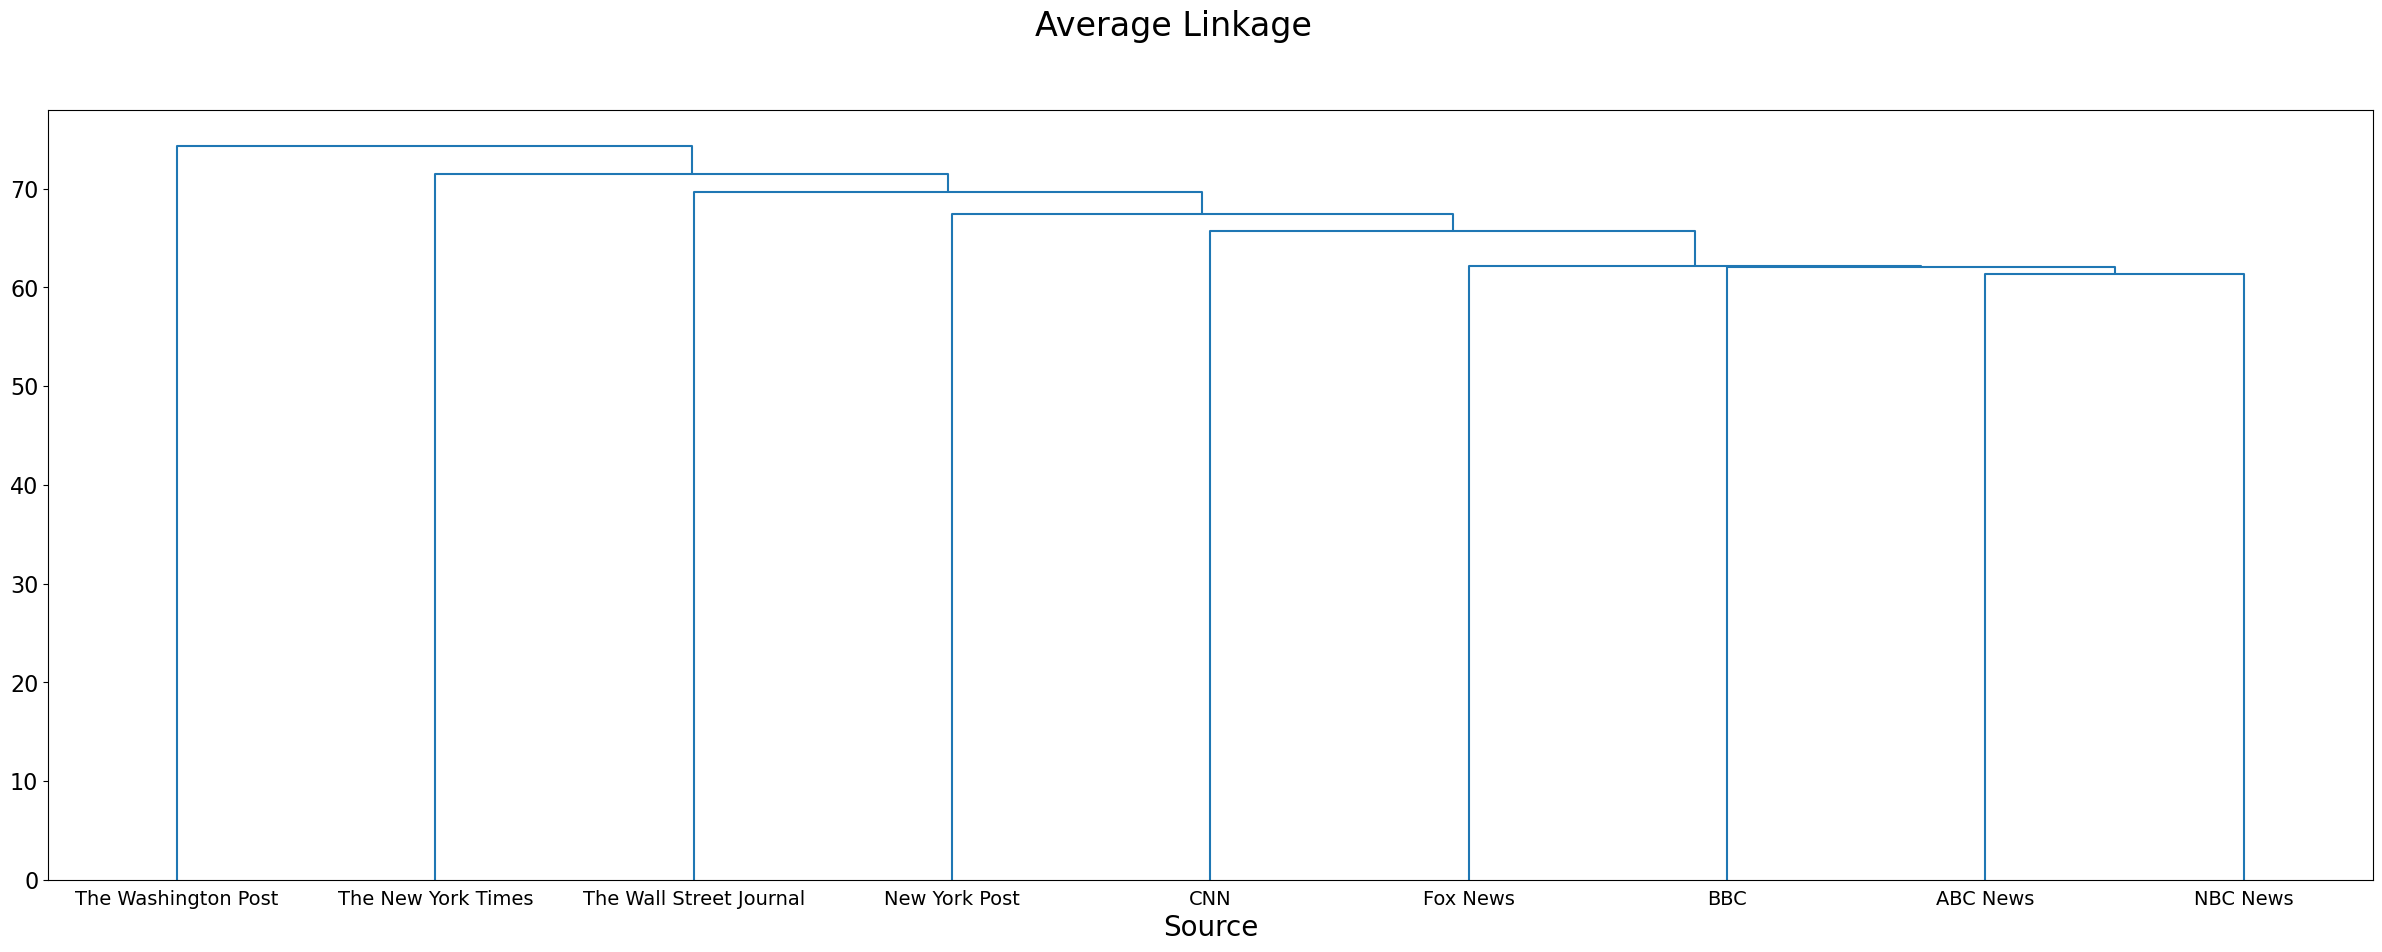

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(tfidf_source_df, 'average')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Average Linkage", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=tfidf_source_df.index)
plt.xticks(fontsize = 14)
plt.show()

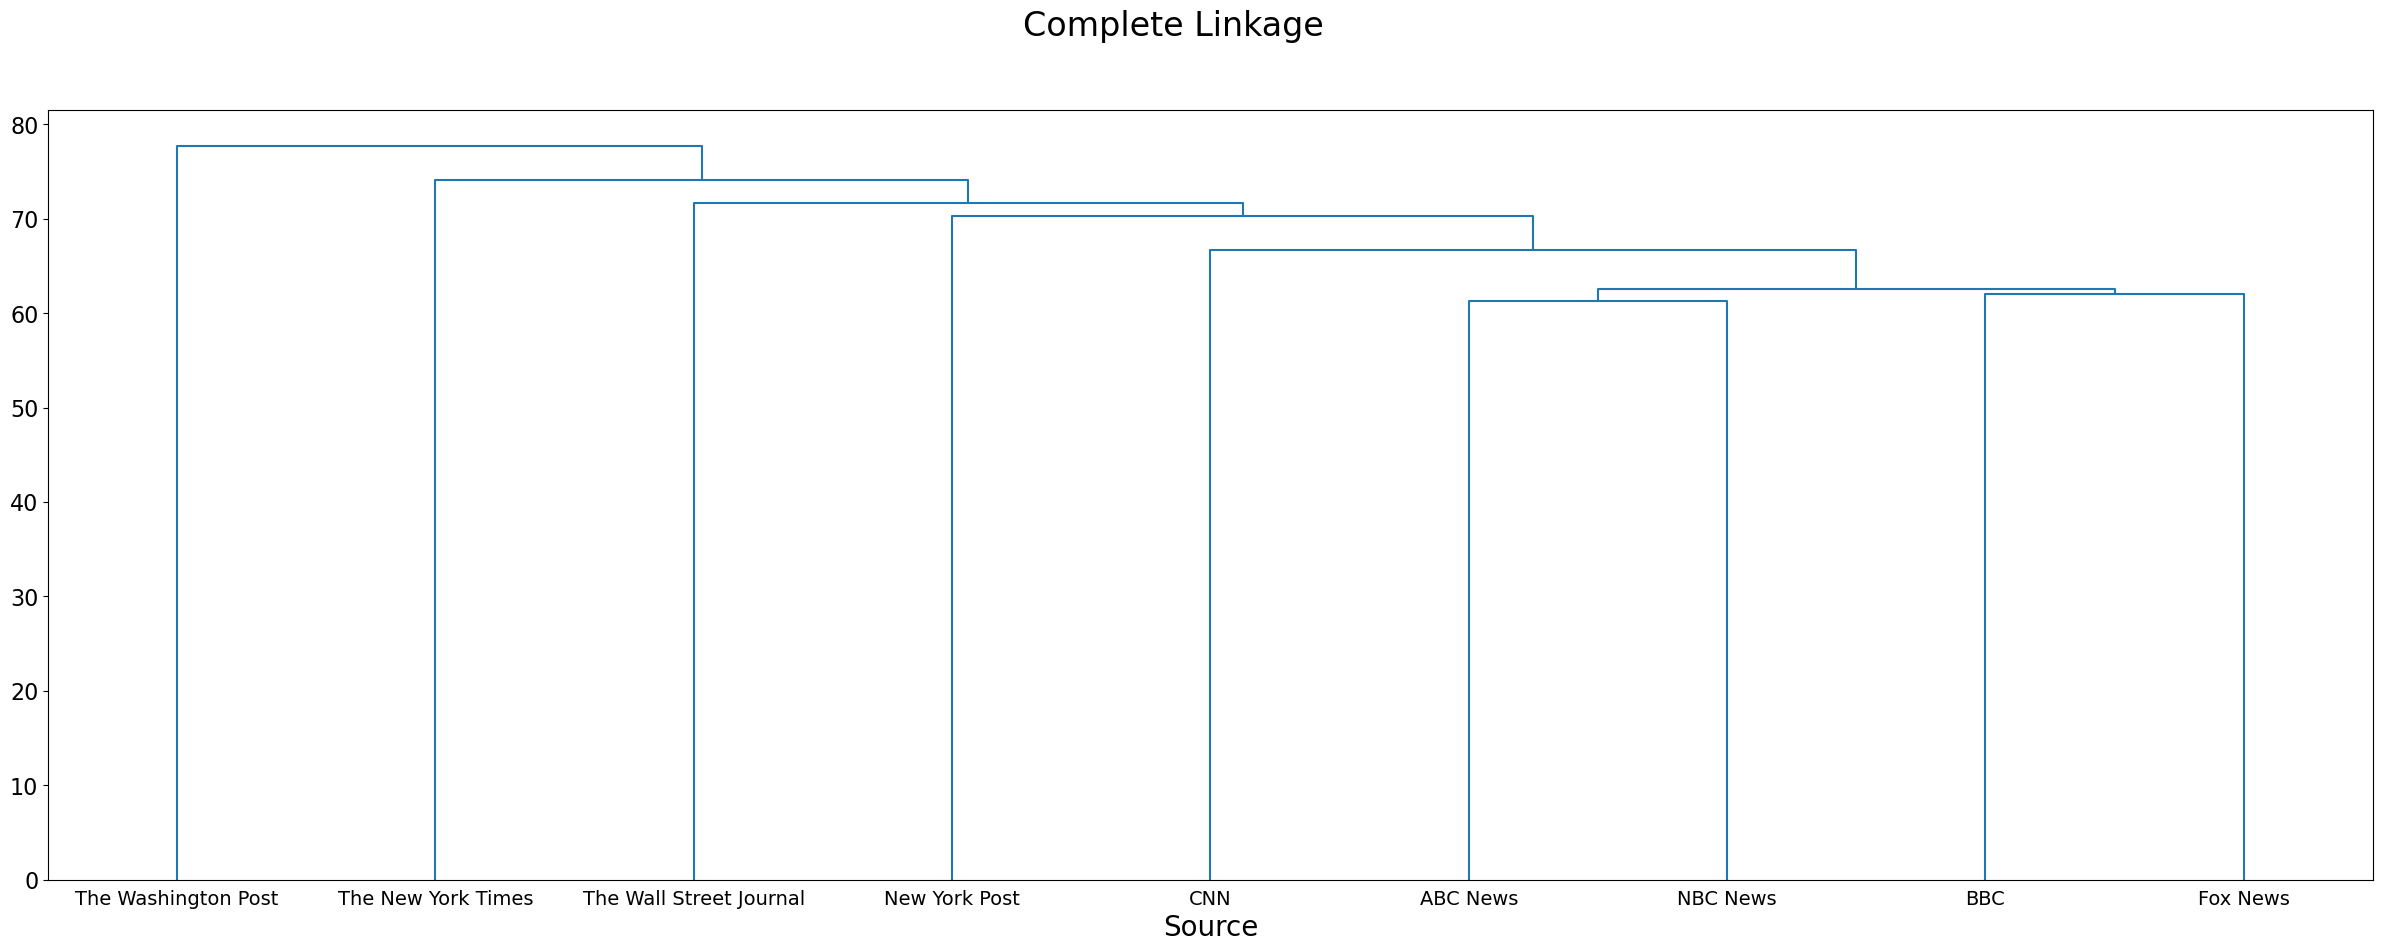

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(tfidf_source_df, 'complete')
fig = plt.figure(figsize=(30, 10))
fig.suptitle("Complete Linkage", fontsize=24)
plt.xlabel('Source', fontsize=20)
plt.yticks(fontsize = 16) 
dn = dendrogram(Z, labels=tfidf_source_df.index)
plt.xticks(fontsize = 14)
plt.show()

In [67]:
def create_wordcloud(text, title):
    '''Given a string of all text and a string
    for the title, creates a wordcloud'''
    wc = WordCloud().generate(text)
    plt.title(title)
    plt.axis("off")
    plt.imshow(wc)

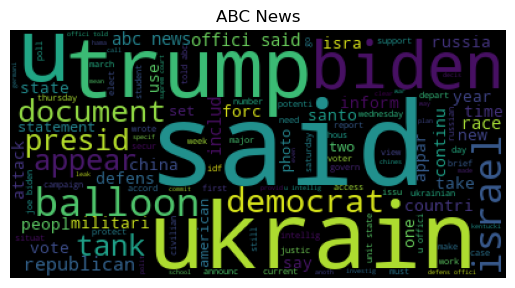

In [68]:
create_wordcloud(source_docs[0], "ABC News")

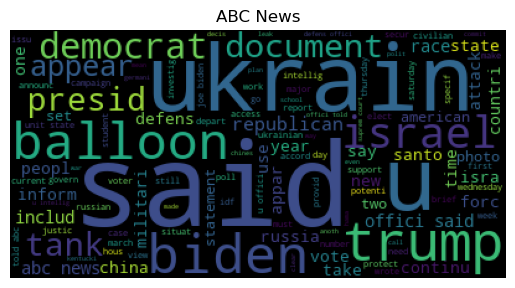

In [66]:
wc = WordCloud().generate(source_docs[0])
plt.title("ABC News")
plt.axis("off")
plt.imshow(wc)

In [ ]:
wc = WordCloud().generate(source_docs[1])
plt.title("ABC News")
plt.axis("off")
plt.imshow(wc)

In [125]:
scores_df = pd.DataFrame({'source':tfidf_df['article_source'], 'topic':tfidf_df['article_topic']})

polarity_scores = []
subjectivity_scores = []

for article in article_docs:
    polarity_scores.append(round(TextBlob(article).sentiment.polarity, 2))
    subjectivity_scores.append(round(TextBlob(article).sentiment.subjectivity, 2))

scores_df['polarity_score'] = polarity_scores
scores_df['subjectivity_score'] = subjectivity_scores

average_topic_polarity_scores = []

for topic in scores_df['topic'].value_counts().index:
    mean_score = round(scores_df[scores_df['topic'] == topic]['polarity_score'].mean(), 2)
    average_topic_polarity_scores.append(mean_score)

scores_df['average_polarity_for_topic'] = average_topic_polarity_scores * 9

average_topic_subjectivity_scores = []

for topic in scores_df['topic'].value_counts().index:
    mean_score = round(scores_df[scores_df['topic'] == topic]['subjectivity_score'].mean(), 2)
    average_topic_subjectivity_scores.append(mean_score)

scores_df['average_subjectivity_for_topic'] = average_topic_subjectivity_scores * 9

scores_df['polarity_diff_from_mean'] = scores_df['polarity_score'] - scores_df['average_polarity_for_topic']
scores_df['subjectivity_diff_from_mean'] = scores_df['subjectivity_score'] - scores_df['average_subjectivity_for_topic']


scores_df.iloc[:10, :]
#average_topic_polarity_scores

,source,topic,polarity_score,subjectivity_score,average_polarity_for_topic,average_subjectivity_for_topic,polarity_diff_from_mean,subjectivity_diff_from_mean
0,ABC News,Supreme Court Ruling on Affirmative Action,0.03,0.40,0.04,0.35,-0.01,0.05
1,ABC News,Chinese Surveillance Balloon,-0.00,0.34,0.01,0.37,-0.01,-0.03
2,ABC News,Biden's Low Approval Rates in Polls,0.14,0.41,0.15,0.40,-0.01,0.01
3,ABC News,The Deadliest Attack by Hamas,0.06,0.36,0.02,0.36,0.04,0.00
4,ABC News,Pentagon Documents Leak,-0.02,0.27,0.00,0.35,-0.02,-0.08
5,ABC News,George Santos' Expulsion from Congress,0.09,0.47,0.12,0.42,-0.03,0.05
6,ABC News,U.S. and Germany Send Tanks to Ukraine,0.02,0.36,0.04,0.31,-0.02,0.05
7,ABC News,Trump's Indictment,0.15,0.43,0.16,0.41,-0.01,0.02
8,BBC,Supreme Court Ruling on Affirmative Action,0.08,0.31,0.04,0.35,0.04,-0.04
9,BBC,Chinese Surveillance Balloon,-0.01,0.35,0.01,0.37,-0.02,-0.02
